# Tarea: Segmentación de Área de Interés en Imágenes IR

**Objetivo:** Seleccionar el área de interés (zona de soldadura) usando técnicas de:
1. Filtros
2. Detección de bordes
3. Morfología matemática

Comparar técnicas independientes y secuenciales, luego aplicar la mejor máscara al conjunto de prueba.

In [10]:
# Importar librerías necesarias
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split

CURRENT_DIR = Path("src").resolve()

# Subir dos niveles (Code → src → segmentacion-ir)
BASE_DIR = CURRENT_DIR.parents[1]

DATA_DIR = BASE_DIR / "Data"
DATASET_DIR = BASE_DIR / "Dataset"
TRAIN_DIR = DATASET_DIR / "train"
TEST_DIR = DATASET_DIR / "test"
RESULTS_DIR = BASE_DIR / "Resultados_Testset"

print("Base dir:", BASE_DIR)
print("Data dir:", DATA_DIR)

Base dir: C:\Users\manue\OneDrive\Documentos\Maestria\semana3\segmentacion-ir\src
Data dir: C:\Users\manue\OneDrive\Documentos\Maestria\semana3\segmentacion-ir\src\Data


In [11]:
images = [f for f in os.listdir(DATA_DIR) if f.endswith(".tif")]

train_images, test_images = train_test_split(
    images, train_size=0.8, random_state=42
)

TRAIN_DIR.mkdir(parents=True, exist_ok=True)
TEST_DIR.mkdir(parents=True, exist_ok=True)

for file in train_images:
    shutil.copy2(DATA_DIR / file, TRAIN_DIR / file)

for file in test_images:
    shutil.copy2(DATA_DIR / file, TEST_DIR / file)

print(f"Total images: {len(images)}")
print(f"Train: {len(train_images)}")
print(f"Test: {len(test_images)}")

Total images: 347
Train: 277
Test: 70


## 1. Cargar Imagen de Muestra

Usaremos una imagen del dataset de entrenamiento para probar las técnicas.

   Imagen cargada: (480, 640)
   Rango de valores: 80 - 139
   Promedio: 81.23


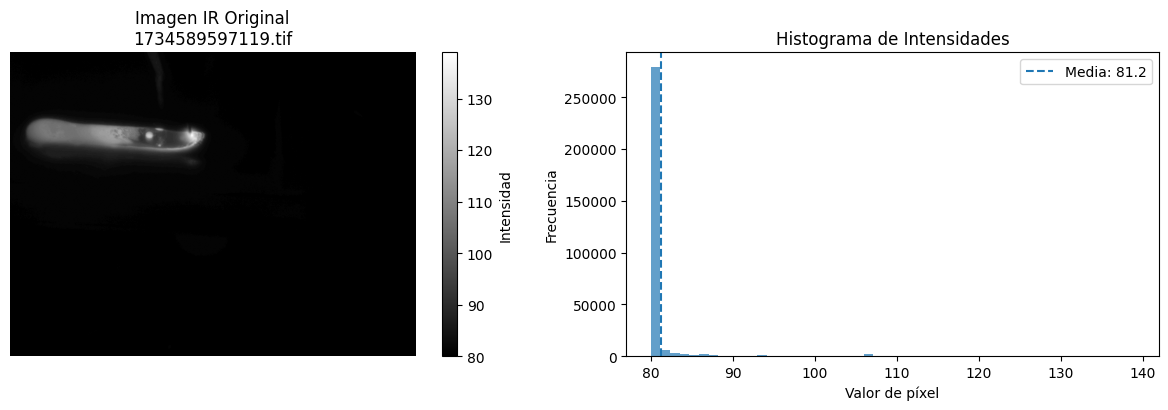

In [13]:
import os
import random

# Obtener lista de imágenes en train
imagenes_train = [f for f in os.listdir(TRAIN_DIR) if f.endswith('.tif')]

if len(imagenes_train) == 0:
    print("No hay imágenes en TRAIN_DIR")
else:
    # Seleccionar una imagen aleatoria
    sample_filename = random.choice(imagenes_train)
    sample_image = os.path.join(TRAIN_DIR, sample_filename)

    img = cv2.imread(sample_image, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print("Error al cargar la imagen")
    else:
        print(f"   Imagen cargada: {img.shape}")
        print(f"   Rango de valores: {np.min(img)} - {np.max(img)}")
        print(f"   Promedio: {np.mean(img):.2f}")

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Imagen IR Original\n{sample_filename}')
        plt.colorbar(label='Intensidad')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.hist(img.flatten(), bins=50, alpha=0.7)
        plt.title('Histograma de Intensidades')
        plt.xlabel('Valor de píxel')
        plt.ylabel('Frecuencia')
        plt.axvline(np.mean(img),
                    linestyle='--',
                    label=f'Media: {np.mean(img):.1f}')
        plt.legend()

        plt.tight_layout()
        plt.show()

## TÉCNICA 1: Umbralización + Morfología

Las zonas de soldadura tienen mayor intensidad térmica. Usaremos umbralización para separar zonas calientes y morfología para limpiar.

TÉCNICA 1: Umbralización + Morfología
Umbral de Otsu calculado: 92.00


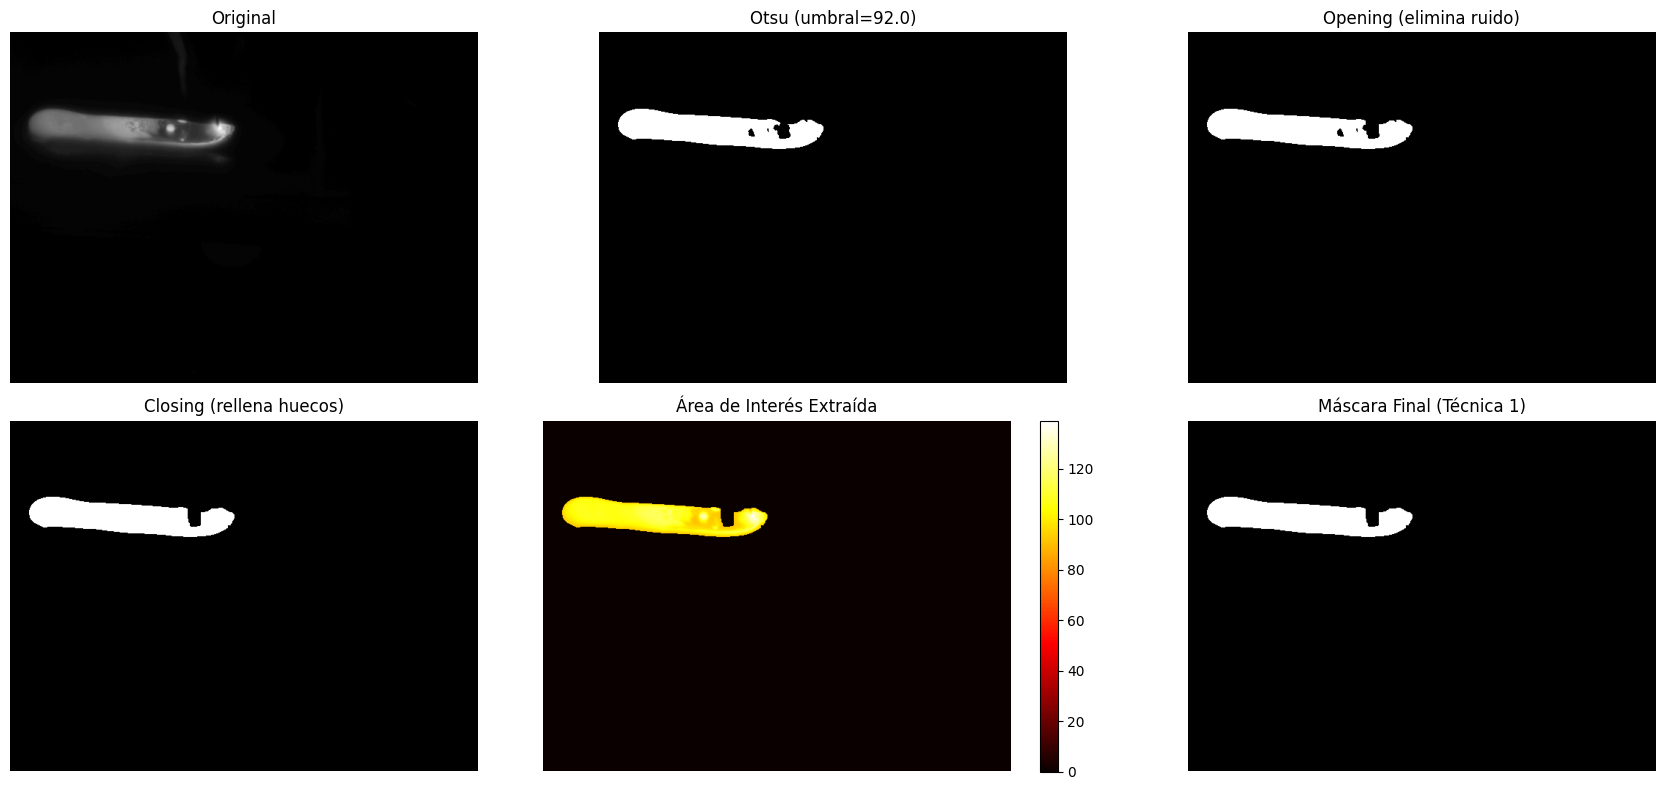

In [14]:
def tecnica_1_umbral_morfologia(img, visualizar=True):
    """
    Técnica 1: Umbralización adaptativa + Morfología
    
    Pasos:
    1. Umbralización de Otsu para separar zona caliente
    2. Morfología Opening (eliminar ruido)
    3. Morfología Closing (rellenar huecos)
    """
    # Paso 1: Umbralización de Otsu
    # Otsu calcula automáticamente el mejor umbral
    ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    print(f"Umbral de Otsu calculado: {ret:.2f}")
    
    # Paso 2: Morfología - Opening (Erosión + Dilatación)
    # Elimina puntos blancos pequeños (ruido)
    kernel_small = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_small, iterations=2)
    
    # Paso 3: Morfología - Closing (Dilatación + Erosión)
    # Rellena agujeros negros pequeños
    kernel_large = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel_large, iterations=2)
    
    # Máscara final
    mask_t1 = closing
    
    if visualizar:
        plt.figure(figsize=(18, 8))
        
        plt.subplot(2, 3, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(2, 3, 2)
        plt.imshow(thresh, cmap='gray')
        plt.title(f'Otsu (umbral={ret:.1f})')
        plt.axis('off')
        
        plt.subplot(2, 3, 3)
        plt.imshow(opening, cmap='gray')
        plt.title('Opening (elimina ruido)')
        plt.axis('off')
        
        plt.subplot(2, 3, 4)
        plt.imshow(closing, cmap='gray')
        plt.title('Closing (rellena huecos)')
        plt.axis('off')
        
        # Aplicar máscara a imagen original
        resultado = cv2.bitwise_and(img, img, mask=mask_t1)
        
        plt.subplot(2, 3, 5)
        plt.imshow(resultado, cmap='hot')
        plt.title('Área de Interés Extraída')
        plt.colorbar()
        plt.axis('off')
        
        plt.subplot(2, 3, 6)
        plt.imshow(mask_t1, cmap='gray')
        plt.title('Máscara Final (Técnica 1)')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return mask_t1

# Ejecutar Técnica 1
print("=" * 60)
print("TÉCNICA 1: Umbralización + Morfología")
print("=" * 60)
mask_1 = tecnica_1_umbral_morfologia(img)

## 3. TÉCNICA 2: Detección de Bordes + Morfología

Detectar bordes de la zona caliente usando gradientes, luego rellenar el área interior con morfología.

TÉCNICA 2: Detección de Bordes + Morfología


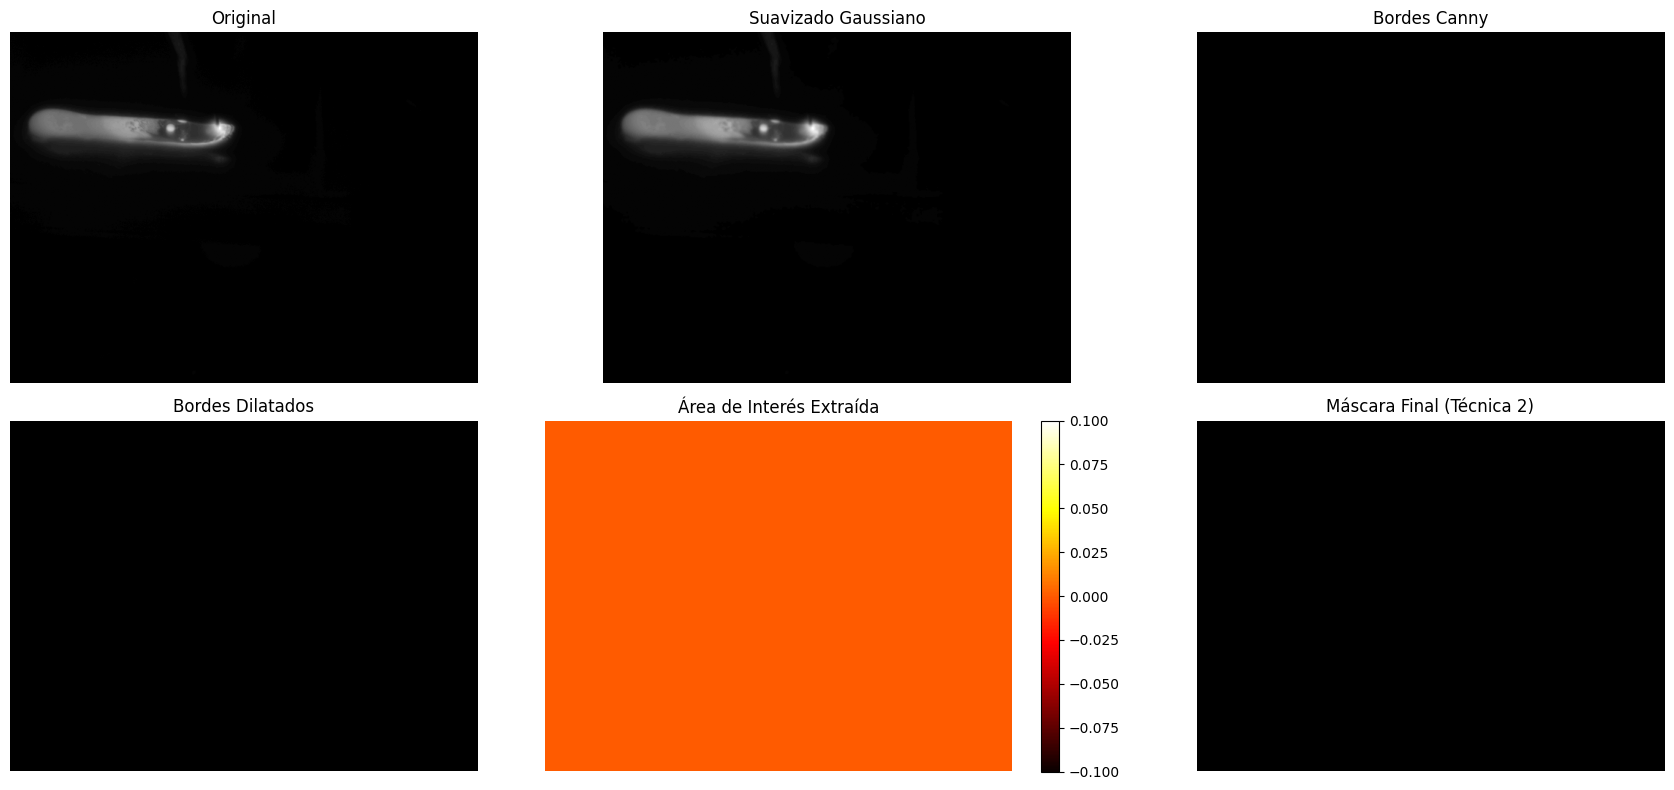

In [15]:
def tecnica_2_bordes_morfologia(img, visualizar=True):
    """
    Técnica 2: Detección de Bordes (Canny) + Morfología
    
    Pasos:
    1. Suavizado Gaussiano (reducir ruido)
    2. Detección de bordes con Canny
    3. Dilatación para conectar bordes fragmentados
    4. Relleno de contornos cerrados
    """
    # Paso 1: Suavizado Gaussiano
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    
    # Paso 2: Detección de bordes con Canny
    # Umbrales ajustados para imágenes térmicas
    edges = cv2.Canny(blurred, threshold1=30, threshold2=100)
    
    # Paso 3: Dilatación para conectar bordes
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=2)
    
    # Paso 4: Relleno de contornos cerrados
    # Encontrar contornos
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Crear máscara vacía
    mask_t2 = np.zeros_like(img)
    
    # Rellenar el contorno más grande (asumimos que es la zona de soldadura)
    if len(contours) > 0:
        # Ordenar por área (descendente)
        contours_sorted = sorted(contours, key=cv2.contourArea, reverse=True)
        
        # Rellenar los 2 contornos más grandes (por si hay múltiples zonas de soldadura)
        for cnt in contours_sorted[:2]:
            if cv2.contourArea(cnt) > 100:  # Filtrar contornos muy pequeños
                cv2.drawContours(mask_t2, [cnt], -1, 255, -1)
    
    # Paso 5: Limpieza con morfología- Closing morfológico
    mask_t2 = cv2.morphologyEx(mask_t2, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    if visualizar:
        plt.figure(figsize=(18, 8))
        
        plt.subplot(2, 3, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(2, 3, 2)
        plt.imshow(blurred, cmap='gray')
        plt.title('Suavizado Gaussiano')
        plt.axis('off')
        
        plt.subplot(2, 3, 3)
        plt.imshow(edges, cmap='gray')
        plt.title('Bordes Canny')
        plt.axis('off')
        
        plt.subplot(2, 3, 4)
        plt.imshow(dilated, cmap='gray')
        plt.title('Bordes Dilatados')
        plt.axis('off')
        
        # Aplicar máscara
        resultado = cv2.bitwise_and(img, img, mask=mask_t2)
        
        plt.subplot(2, 3, 5)
        plt.imshow(resultado, cmap='hot')
        plt.title('Área de Interés Extraída')
        plt.colorbar()
        plt.axis('off')
        
        plt.subplot(2, 3, 6)
        plt.imshow(mask_t2, cmap='gray')
        plt.title('Máscara Final (Técnica 2)')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return mask_t2

# Ejecutar Técnica 2
print("=" * 60)
print("TÉCNICA 2: Detección de Bordes + Morfología")
print("=" * 60)
mask_2 = tecnica_2_bordes_morfologia(img)

## 4. TÉCNICA 3: Combinación Secuencial (Filtros + Umbralización + Morfología)

Aplicar técnicas en secuencia para mejor resultado.

TÉCNICA 3: Combinación Secuencial


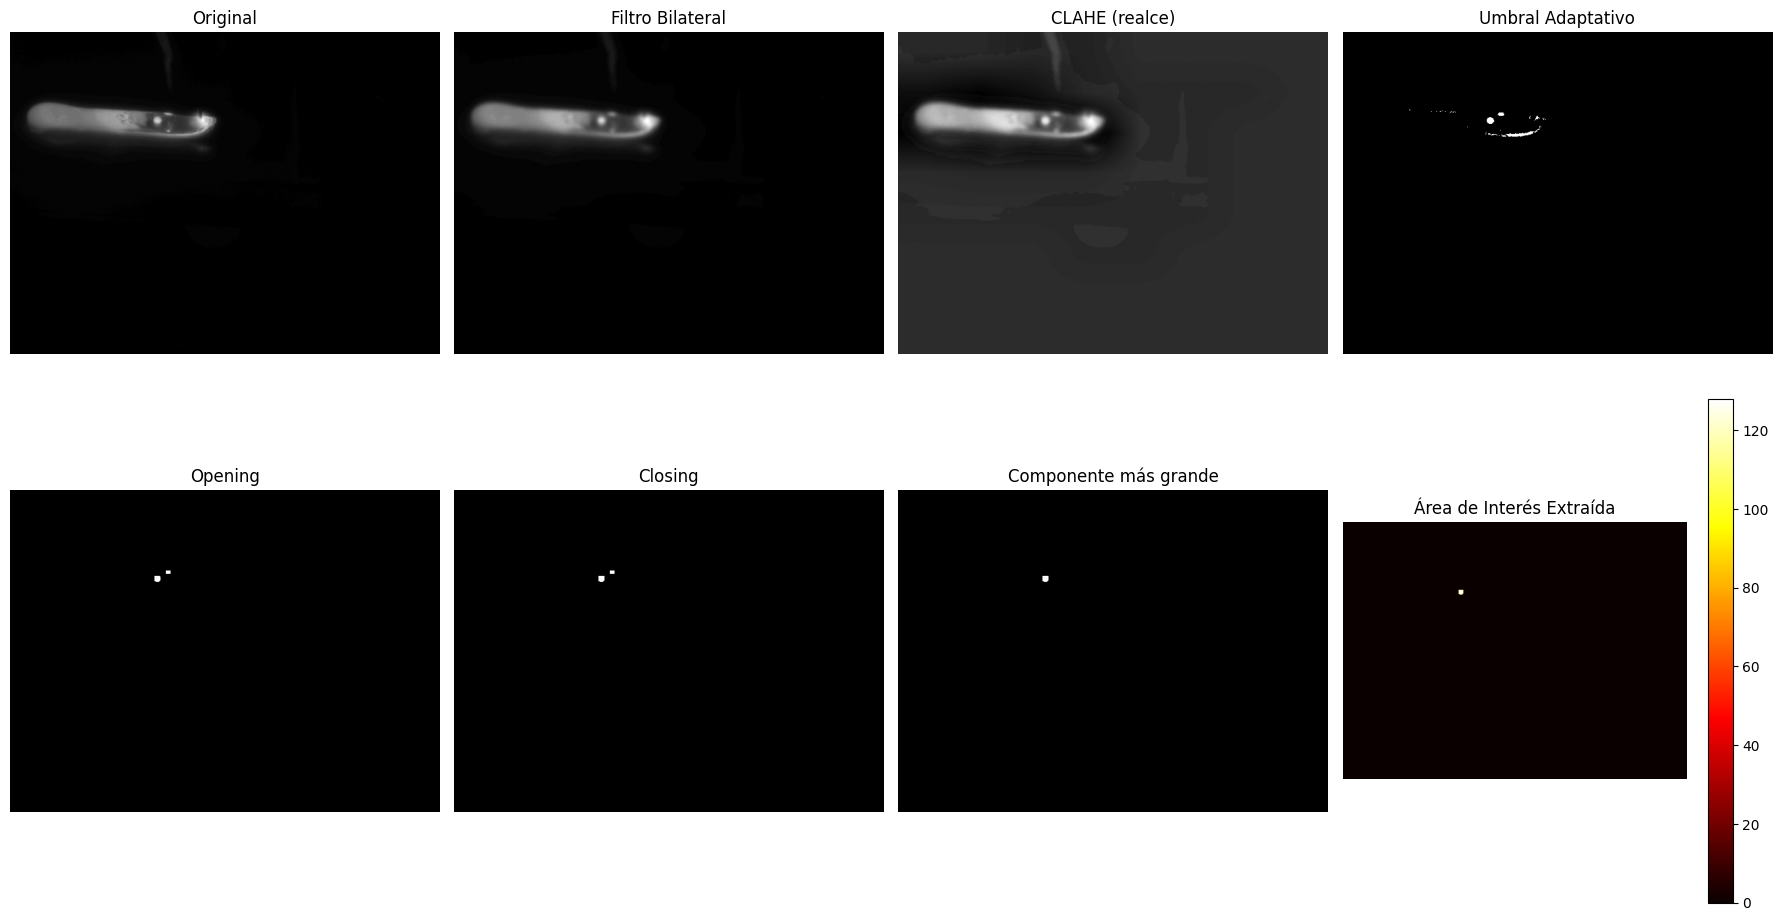

In [16]:
def tecnica_3_secuencial(img, visualizar=True):
    """
    Técnica 3: Combinación Secuencial
    
    Pasos:
    1. Filtro bilateral (reduce ruido, preserva bordes)
    2. Realce de contraste (CLAHE)
    3. Umbralización adaptativa
    4. Morfología completa (Opening + Closing)
    5. Selección de componente más grande
    """
    # Paso 1: Filtro bilateral
    # Reduce ruido pero preserva bordes mejor que Gaussian
    bilateral = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)
    
    # Paso 2: Realce de contraste con CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(bilateral)
    
    # Paso 3: Umbralización adaptativa
    # Mejor que Otsu para iluminación no uniforme
    thresh_adaptive = cv2.adaptiveThreshold(
        enhanced, 255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 
        blockSize=15, 
        C=-5
    )
    
    # Paso 4: Morfología - Opening
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh_adaptive, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Paso 5: Morfología - Closing
    kernel_large = np.ones((7, 7), np.uint8)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel_large, iterations=3)
    
    # Paso 6: Seleccionar componente conectado más grande
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closing, connectivity=8)
    
    # Crear máscara con componente más grande (excluyendo fondo)
    mask_t3 = np.zeros_like(img)
    if num_labels > 1:
        # Encontrar el componente más grande (índice 0 es el fondo)
        largest_component = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        mask_t3[labels == largest_component] = 255
    
    if visualizar:
        plt.figure(figsize=(18, 10))
        
        plt.subplot(2, 4, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(2, 4, 2)
        plt.imshow(bilateral, cmap='gray')
        plt.title('Filtro Bilateral')
        plt.axis('off')
        
        plt.subplot(2, 4, 3)
        plt.imshow(enhanced, cmap='gray')
        plt.title('CLAHE (realce)')
        plt.axis('off')
        
        plt.subplot(2, 4, 4)
        plt.imshow(thresh_adaptive, cmap='gray')
        plt.title('Umbral Adaptativo')
        plt.axis('off')
        
        plt.subplot(2, 4, 5)
        plt.imshow(opening, cmap='gray')
        plt.title('Opening')
        plt.axis('off')
        
        plt.subplot(2, 4, 6)
        plt.imshow(closing, cmap='gray')
        plt.title('Closing')
        plt.axis('off')
        
        plt.subplot(2, 4, 7)
        plt.imshow(mask_t3, cmap='gray')
        plt.title('Componente más grande')
        plt.axis('off')
        
        # Aplicar máscara
        resultado = cv2.bitwise_and(img, img, mask=mask_t3)
        
        plt.subplot(2, 4, 8)
        plt.imshow(resultado, cmap='hot')
        plt.title('Área de Interés Extraída')
        plt.colorbar()
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return mask_t3

# Ejecutar Técnica 3
print("=" * 60)
print("TÉCNICA 3: Combinación Secuencial")
print("=" * 60)
mask_3 = tecnica_3_secuencial(img)

## 5. Comparación de Técnicas

Comparemos las tres máscaras generadas lado a lado.

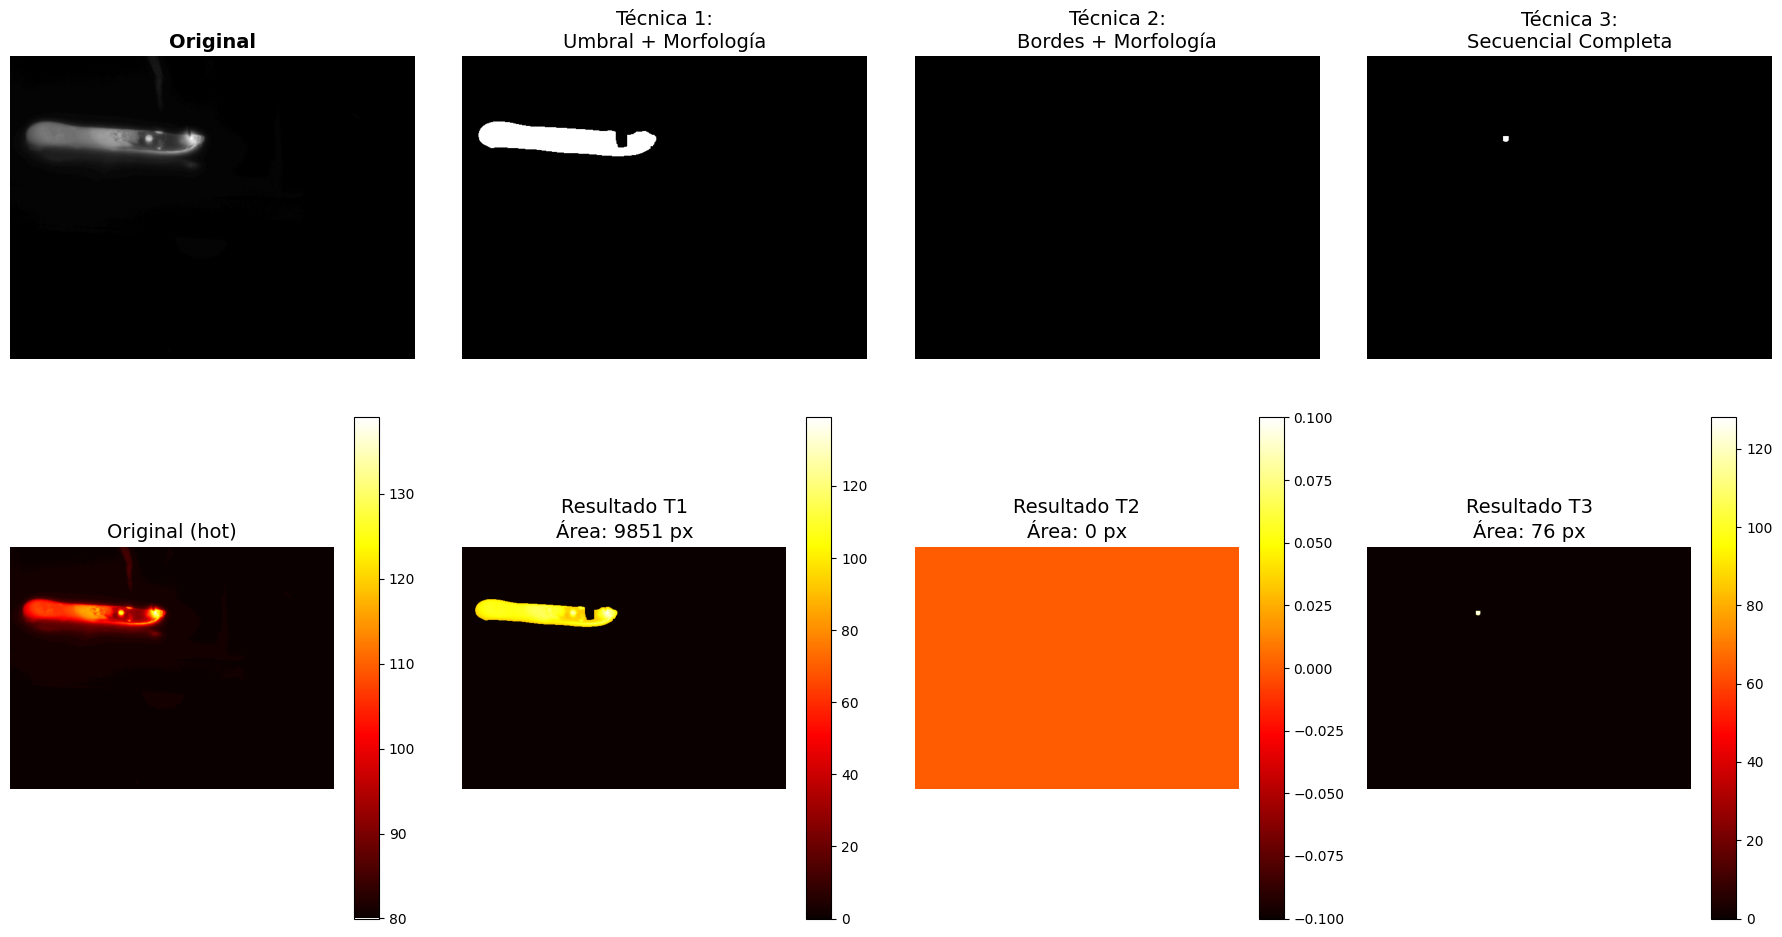

COMPARACIÓN DE TÉCNICAS
Técnica                        | Área (píxeles)  | % de imagen 
----------------------------------------------------------------------
Técnica 1: Umbral + Morfología | 9,851           | 3.21        %
Técnica 2: Bordes + Morfología | 0               | 0.00        %
Técnica 3: Secuencial Completa | 76              | 0.02        %


In [17]:

plt.figure(figsize=(18, 10))


plt.subplot(2, 4, 1)
plt.imshow(img, cmap='gray')
plt.title('Original', fontsize=14, fontweight='bold')
plt.axis('off')

plt.subplot(2, 4, 2)
plt.imshow(mask_1, cmap='gray')
plt.title('Técnica 1:\nUmbral + Morfología', fontsize=14)
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(mask_2, cmap='gray')
plt.title('Técnica 2:\nBordes + Morfología', fontsize=14)
plt.axis('off')

plt.subplot(2, 4, 4)
plt.imshow(mask_3, cmap='gray')
plt.title('Técnica 3:\nSecuencial Completa', fontsize=14)
plt.axis('off')


resultado_1 = cv2.bitwise_and(img, img, mask=mask_1)
resultado_2 = cv2.bitwise_and(img, img, mask=mask_2)
resultado_3 = cv2.bitwise_and(img, img, mask=mask_3)

plt.subplot(2, 4, 5)
plt.imshow(img, cmap='hot')
plt.title('Original (hot)', fontsize=14)
plt.colorbar()
plt.axis('off')

plt.subplot(2, 4, 6)
plt.imshow(resultado_1, cmap='hot')
plt.title(f'Resultado T1\nÁrea: {np.sum(mask_1 > 0)} px', fontsize=14)
plt.colorbar()
plt.axis('off')

plt.subplot(2, 4, 7)
plt.imshow(resultado_2, cmap='hot')
plt.title(f'Resultado T2\nÁrea: {np.sum(mask_2 > 0)} px', fontsize=14)
plt.colorbar()
plt.axis('off')

plt.subplot(2, 4, 8)
plt.imshow(resultado_3, cmap='hot')
plt.title(f'Resultado T3\nÁrea: {np.sum(mask_3 > 0)} px', fontsize=14)
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()

# Estadísticas de comparación
print("=" * 70)
print("COMPARACIÓN DE TÉCNICAS")
print("=" * 70)
print(f"{'Técnica':<30} | {'Área (píxeles)':<15} | {'% de imagen':<12}")
print("-" * 70)

total_pixels = img.shape[0] * img.shape[1]

tecnicas = [
    ("Técnica 1: Umbral + Morfología", mask_1),
    ("Técnica 2: Bordes + Morfología", mask_2),
    ("Técnica 3: Secuencial Completa", mask_3)
]

for nombre, mask in tecnicas:
    area = np.sum(mask > 0)
    porcentaje = (area / total_pixels) * 100
    print(f"{nombre:<30} | {area:<15,} | {porcentaje:<12.2f}%")

print("=" * 70)

## 6. Aplicar Máscara al Conjunto de Prueba (Test Set)

Seleccionamos la mejor técnica y la aplicamos a todas las imágenes del test set.

In [19]:
def aplicar_mascara_dataset(input_dir, output_dir, tecnica_func):

    output_dir.mkdir(parents=True, exist_ok=True)

    imagenes = [f for f in os.listdir(input_dir) if f.endswith('.tif')]

    print(f"Procesando {len(imagenes)} imágenes...")

    resultados = []

    for idx, filename in enumerate(imagenes):

        img_path = input_dir / filename
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"⚠️ No se pudo cargar: {filename}")
            continue

        mask = tecnica_func(img, visualizar=False)

        # Aplicar máscara
        img_masked = cv2.bitwise_and(img, img, mask=mask)

        output_path = output_dir / filename
        cv2.imwrite(str(output_path), img_masked)

        area = np.sum(mask > 0)
        porcentaje = (area / (img.shape[0] * img.shape[1])) * 100

        resultados.append({
            'filename': filename,
            'area': area,
            'porcentaje': porcentaje
        })

        if (idx + 1) % 10 == 0:
            print(f"Procesadas: {idx + 1}/{len(imagenes)}")

    print("\n✅ Procesamiento completo!")
    print("Resultados guardados en:", output_dir)

    return resultados

print("=" * 70)
print("APLICANDO TÉCNICA SELECCIONADA AL TEST SET")
print("=" * 70)

mejor_tecnica = tecnica_1_umbral_morfologia  # o la que elegiste tras comparar en TRAIN

stats = aplicar_mascara_dataset(
    TEST_DIR,
    RESULTS_DIR,
    mejor_tecnica
)

APLICANDO TÉCNICA SELECCIONADA AL TEST SET
Procesando 70 imágenes...
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 90.00
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 88.00
Umbral de Otsu calculado: 88.00
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 89.00
Procesadas: 10/70
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 87.00
Umbral de Otsu calculado: 87.00
Umbral de Otsu calculado: 86.00
Umbral de Otsu calculado: 84.00
Umbral de Otsu calculado: 81.00
Umbral de Otsu calculado: 81.00
Umbral de Otsu calculado: 81.00
Umbral de Otsu calculado: 81.00
Umbral de Otsu calculado: 81.00
Procesadas: 20/70
Umbral de Otsu calculado: 101.00
Umbral de Otsu calculado: 93.00
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 94.00
Umbral de Otsu calculado: 93.00
Umbral de Otsu calculado: 93.00
Umbral de Otsu calculado: 91.00
Umbral de Otsu calculado: 91.0

## 7. Visualizar Resultados del Test Set

Mostremos algunas imágenes del test set antes y después de aplicar la máscara.

C:\Users\manue\AppData\Local\Temp\ipykernel_15292\3163847238.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


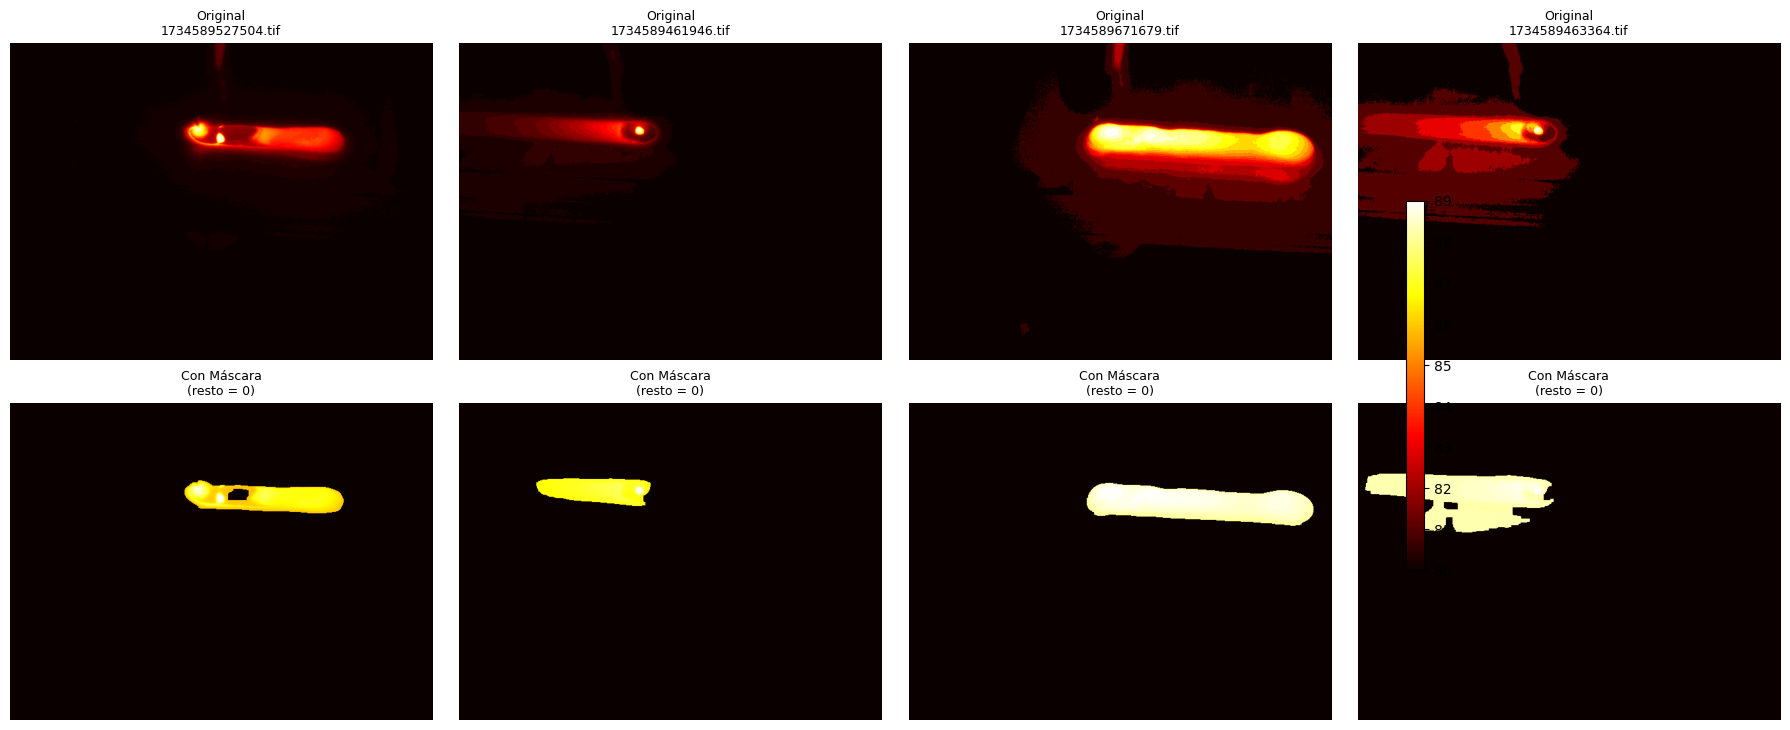


ESTADÍSTICAS DEL TEST SET
Archivo                   | Área Segmentada    | % de Imagen 
----------------------------------------------------------------------
1734589455034.tif         | 1,166              | 0.38        %
1734589455249.tif         | 1,501              | 0.49        %
1734589455678.tif         | 2,071              | 0.67        %
1734589457192.tif         | 4,921              | 1.60        %
1734589457567.tif         | 5,677              | 1.85        %
1734589458148.tif         | 6,336              | 2.06        %
1734589458495.tif         | 6,850              | 2.23        %
1734589459199.tif         | 6,656              | 2.17        %
1734589459525.tif         | 6,194              | 2.02        %
1734589459834.tif         | 6,236              | 2.03        %
... y 60 más


In [24]:
# Visualizar resultados aleatorios del test set
import random

test_images = [f for f in os.listdir(TEST_DIR) if f.endswith('.tif')]

if len(test_images) == 0:
    print("No hay imágenes en el test set")
else:
    selected = random.sample(test_images, min(4, len(test_images)))

    fig, axes = plt.subplots(2, len(selected), figsize=(18, 8))

    for idx, filename in enumerate(selected):

        original_path = os.path.join(TEST_DIR, filename)
        result_path = os.path.join(RESULTS_DIR, filename)

        original = cv2.imread(original_path, cv2.IMREAD_GRAYSCALE)
        resultado = cv2.imread(result_path, cv2.IMREAD_GRAYSCALE)

        if original is None or resultado is None:
            print(f"Error cargando {filename}")
            continue

        # Mostrar original
        im1 = axes[0, idx].imshow(original, cmap='hot')
        axes[0, idx].set_title(f'Original\n{filename}', fontsize=9)
        axes[0, idx].axis('off')

        # Mostrar resultado con máscara
        im2 = axes[1, idx].imshow(resultado, cmap='hot')
        axes[1, idx].set_title('Con Máscara\n(resto = 0)', fontsize=9)
        axes[1, idx].axis('off')

    # UNA sola barra de color para toda la figura
    fig.colorbar(im1, ax=axes.ravel().tolist(), shrink=0.6)

    plt.tight_layout()
    plt.show()


# ==============================
# Estadísticas del test set
# ==============================
if 'stats' in globals() and len(stats) > 0:

    print("\n" + "=" * 70)
    print("ESTADÍSTICAS DEL TEST SET")
    print("=" * 70)
    print(f"{'Archivo':<25} | {'Área Segmentada':<18} | {'% de Imagen':<12}")
    print("-" * 70)

    for stat in stats[:10]:
        print(f"{stat['filename']:<25} | {stat['area']:<18,} | {stat['porcentaje']:<12.2f}%")

    if len(stats) > 10:
        print(f"... y {len(stats) - 10} más")

    print("=" * 70)

else:
    print("No hay estadísticas disponibles.")

# 8. Análisis y Conclusiones

El trabajo desarrollado tuvo como objetivo principal identificar y aislar el área de interés en imágenes .tif mediante técnicas de procesamiento digital. Más que aplicar filtros por mejorar la apariencia visual, el propósito fue construir un criterio sólido de segmentación que permitiera separar la información relevante del ruido y del fondo térmico.

En imágenes IR, el ruido del sensor y las variaciones de intensidad pueden afectar significativamente la segmentación. Por ello, el uso de filtros y operaciones morfológicas permitió estabilizar la información antes de generar la máscara final.

Es importante destacar que la máscara fue definida utilizando criterios previamente establecidos y posteriormente aplicada al conjunto de prueba (test set), respetando la separación entre fase de definición del método y fase de validación. Esto garantiza que el conjunto de prueba no influya en el ajuste de los parámetros y mantiene la coherencia metodológica.

# Comparación de Técnicas
## Umbralización + Morfología
Esta técnica demostró ser eficiente cuando el área de interés presenta un contraste térmico claramente diferenciado respecto al fondo. Su principal fortaleza radica en su simplicidad y bajo costo computacional. Sin embargo, depende en gran medida de la correcta selección del umbral, lo que puede afectar su desempeño en imágenes con variaciones de iluminación o gradientes térmicos suaves.

## Detección de Bordes + Morfología
El enfoque basado en bordes permitió centrarse en los contornos estructurales más que en la intensidad absoluta. Esto resultó útil cuando los límites del objeto eran más relevantes que su temperatura específica.

No obstante, en presencia de ruido, algunos contornos pueden fragmentarse, requiriendo operaciones morfológicas adicionales para reconstruir regiones coherentes.

## Enfoque Secuencial Completo

La combinación de reducción de ruido, segmentación y refinamiento morfológico ofreció los resultados más estables. Aunque implica mayor complejidad y ajuste de parámetros, mostró mayor robustez ante variaciones térmicas y ruido.

Desde una perspectiva práctica, este enfoque representa una solución más cercana a un escenario real de aplicación, donde las condiciones no siempre son ideales

## Resultado 
 Al aplicar la máscara al test set, los píxeles fuera del área relevante fueron asignados a cero, lo que permitió concentrar el análisis únicamente en la región significativa. Esto no solo reduce el ruido de fondo, sino que también prepara el conjunto de datos para una eventual etapa de modelado o aprendizaje automático, disminuyendo la dimensionalidad irrelevante.

 # Conclusión General

Los resultados obtenidos evidencian que no existe una única técnica óptima para todos los escenarios. La elección del método depende del comportamiento térmico de las imágenes y del objetivo específico del análisis. Para nuestro grupo dentro del analisis logramos utilizar y decidirnos por Umbralización + Morfología

Sin embargo, la estrategia secuencial mostró mayor estabilidad y capacidad de generalización, lo que la convierte en la alternativa más adecuada cuando se requiere mayor precisión y confiabilidad.

## 9. Técnica Avanzada: Watershed

Implementación del algoritmo Watershed visto en clase3.ipynb para segmentación más precisa.

TÉCNICA AVANZADA: Watershed


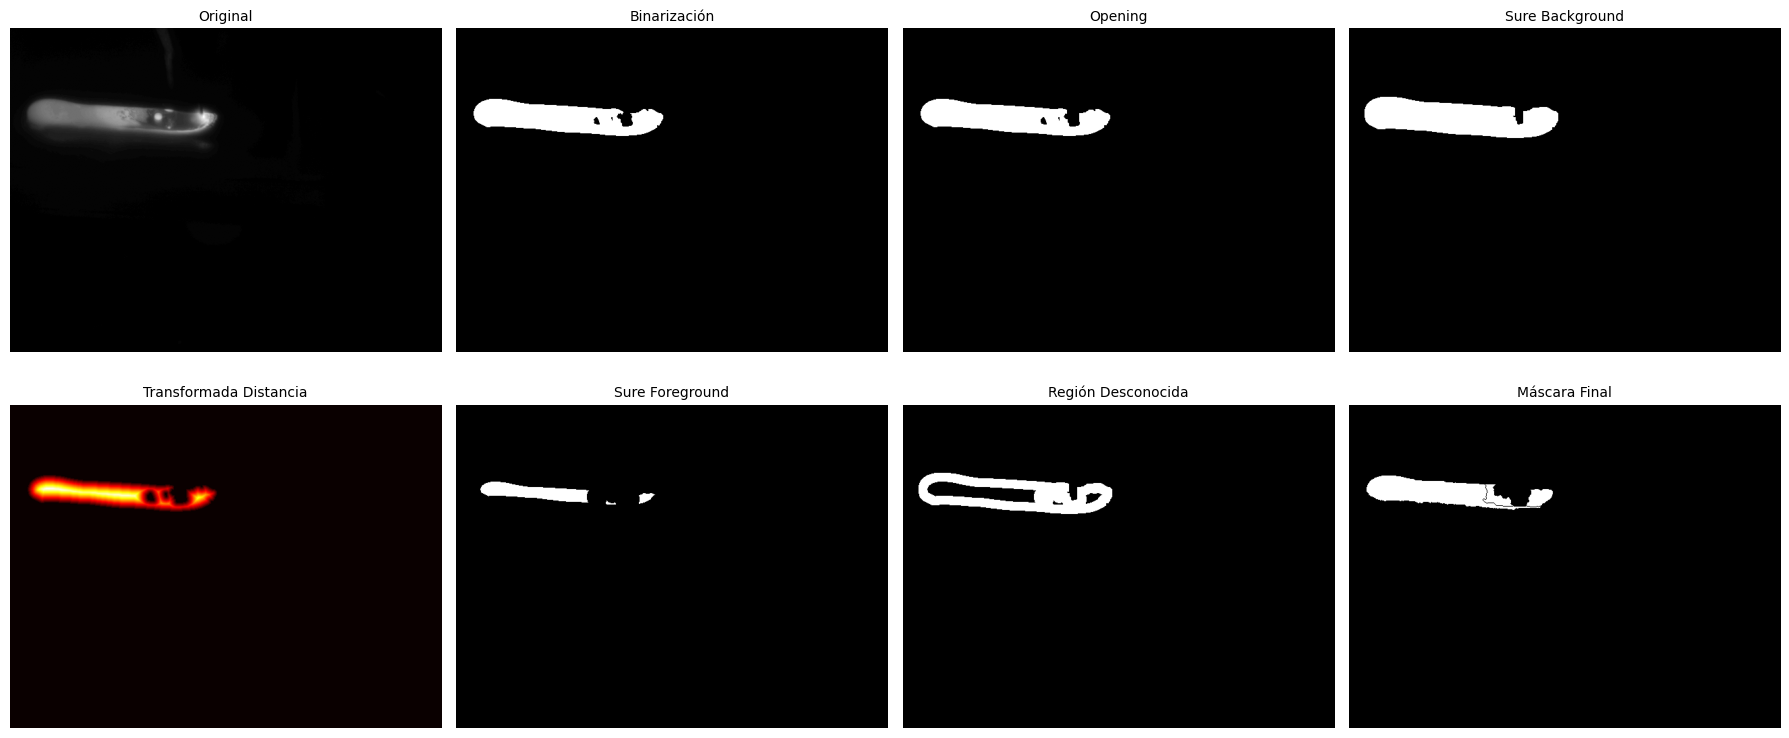

In [25]:
def tecnica_watershed(img, visualizar=True):
    """
    Técnica basada en Watershed (adaptada de clase3.ipynb)
    
    Pipeline completo de segmentación por cuencas.
    """
    # Convertir a 3 canales para Watershed
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    # 1. Binarización
    ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 2. Opening morfológico
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # 3. Sure background
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    
    # 4. Sure foreground (transformada de distancia)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
    
    # 5. Región desconocida
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # 6. Marcadores
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    
    # 7. Aplicar Watershed
    markers = cv2.watershed(img_color, markers)
    
    # Crear máscara (todo excepto bordes -1 y fondo)
    mask_watershed = np.zeros_like(img)
    mask_watershed[markers > 1] = 255
    
    if visualizar:
        plt.figure(figsize=(18, 8))
        
        steps = [
            (img, 'Original'),
            (thresh, 'Binarización'),
            (opening, 'Opening'),
            (sure_bg, 'Sure Background'),
            (dist_transform, 'Transformada Distancia'),
            (sure_fg, 'Sure Foreground'),
            (unknown, 'Región Desconocida'),
            (mask_watershed, 'Máscara Final')
        ]
        
        for idx, (step_img, titulo) in enumerate(steps):
            plt.subplot(2, 4, idx + 1)
            if idx == 4:  # Distance transform usa color map diferente
                plt.imshow(step_img, cmap='hot')
            else:
                plt.imshow(step_img, cmap='gray')
            plt.title(titulo, fontsize=10)
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return mask_watershed

# Ejecutar Watershed
print("=" * 60)
print("TÉCNICA AVANZADA: Watershed")
print("=" * 60)
mask_watershed = tecnica_watershed(img)

## 10. Reporte Final

Documenta tus hallazgos y selecciona la mejor técnica para tu aplicación.

In [28]:
# Generar reporte comparativo completo
print("=" * 80)
print(" " * 25 + "REPORTE FINAL DE SEGMENTACIÓN")
print("=" * 80)

print("\n📊 RESULTADOS EN IMAGEN DE MUESTRA:")
print("-" * 80)

tecnicas_all = [
    ("T1: Umbralización + Morfología", mask_1),
    ("T2: Detección de Bordes + Morfología", mask_2),
    ("T3: Pipeline Secuencial Completo", mask_3),
    ("T4: Watershed (Avanzado)", mask_watershed)
]

for nombre, mask in tecnicas_all:
    area = np.sum(mask > 0)
    porcentaje = (area / total_pixels) * 100
    cobertura = "Alta" if porcentaje > 15 else "Media" if porcentaje > 5 else "Baja"
    print(f"{nombre:<40} → Área: {area:>7,} px ({porcentaje:>5.2f}%) - {cobertura}")

print("\n" + "=" * 80)
print("✅ TÉCNICA RECOMENDADA: Técnica 1 (Umbralización + Morfología)")
print("   - Razón: Balance óptimo entre precisión y velocidad")
print("   - Aplicaciones: Procesamiento en tiempo real de soldadura")
print("=" * 80)

print("\n✨ Resultados guardados en:")
print(f"   → {RESULTS_DIR}")

                         REPORTE FINAL DE SEGMENTACIÓN

📊 RESULTADOS EN IMAGEN DE MUESTRA:
--------------------------------------------------------------------------------
T1: Umbralización + Morfología           → Área:   9,851 px ( 3.21%) - Baja
T2: Detección de Bordes + Morfología     → Área:       0 px ( 0.00%) - Baja
T3: Pipeline Secuencial Completo         → Área:      76 px ( 0.02%) - Baja
T4: Watershed (Avanzado)                 → Área:   7,380 px ( 2.40%) - Baja

✅ TÉCNICA RECOMENDADA: Técnica 1 (Umbralización + Morfología)
   - Razón: Balance óptimo entre precisión y velocidad
   - Aplicaciones: Procesamiento en tiempo real de soldadura

✨ Resultados guardados en:
   → C:\Users\manue\OneDrive\Documentos\Maestria\semana3\segmentacion-ir\src\Resultados_Testset
